In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [17]:
from vctr.data.data_loader import get_data
df = get_data('NEAR', '1h', start='2023-01-01')
df.head()

,volume,open,close,high,low
date,,,,,
2023-01-01 00:00:00+00:00,35112.236648,1.2591,1.246,1.2591,1.245
2023-01-01 01:00:00+00:00,3550.805450,1.2450,1.247,1.2483,1.241
2023-01-01 02:00:00+00:00,4103.217324,1.2460,1.250,1.2547,1.243
2023-01-01 03:00:00+00:00,7710.705565,1.2490,1.250,1.2541,1.245
2023-01-01 04:00:00+00:00,6979.635536,1.2500,1.239,1.2539,1.239


In [18]:
close = df.close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [19]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [20]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('hour %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'hour %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [22]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [23]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 0 with accuracy 0.107544
epoch 10, fittest individual 0 with accuracy 0.107544
epoch 15, fittest individual 0 with accuracy 0.107544
epoch 20, fittest individual 0 with accuracy 0.107544
epoch 25, fittest individual 0 with accuracy 0.191691
epoch 30, fittest individual 0 with accuracy 0.191691
epoch 35, fittest individual 0 with accuracy 0.191691
epoch 40, fittest individual 0 with accuracy 0.191691
epoch 45, fittest individual 0 with accuracy 0.191691
epoch 50, fittest individual 0 with accuracy 0.191691


In [24]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets)

hour 1: buy 1 unit at price 1.247000, total balance 9998.753000
hour 2: buy 1 unit at price 1.250000, total balance 9997.503000
hour 5, sell 1 unit at price 1.243000, investment -0.320770 %, total balance 9998.746000,
hour 6, sell 1 unit at price 1.244000, investment -0.480000 %, total balance 9999.990000,
hour 7: buy 1 unit at price 1.244000, total balance 9998.746000
hour 9, sell 1 unit at price 1.248000, investment 0.321543 %, total balance 9999.994000,
hour 10: buy 1 unit at price 1.249000, total balance 9998.745000
hour 12, sell 1 unit at price 1.256000, investment 0.560448 %, total balance 10000.001000,
hour 14: buy 1 unit at price 1.253000, total balance 9998.748000
hour 15, sell 1 unit at price 1.255000, investment 0.159617 %, total balance 10000.003000,
hour 16: buy 1 unit at price 1.261100, total balance 9998.741900
hour 18: buy 1 unit at price 1.274000, total balance 9997.467900
hour 19: buy 1 unit at price 1.277000, total balance 9996.190900
hour 20: buy 1 unit at price 1.2

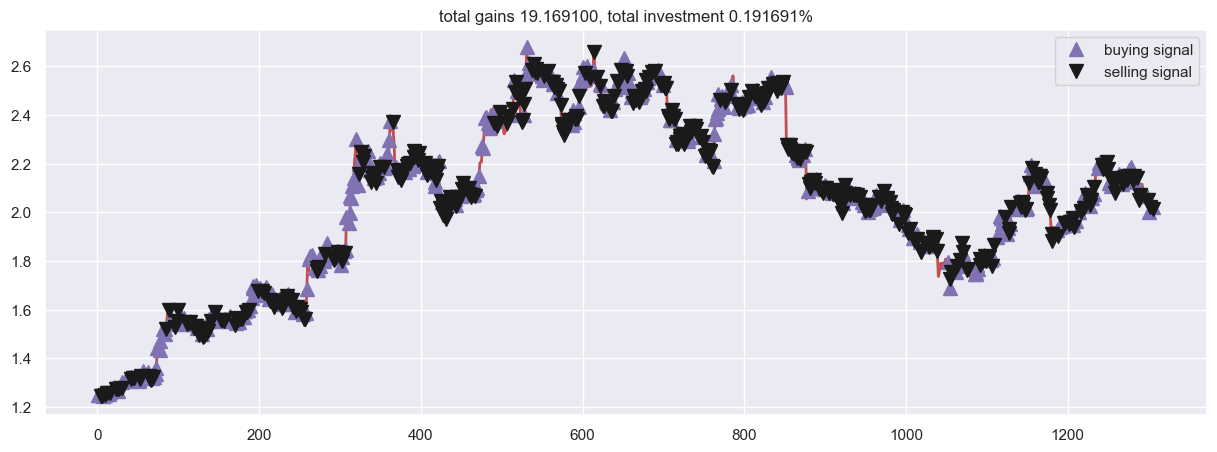

In [25]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()